In [129]:
## Initial Setup

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

import pandas as pd
import numpy

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


bs = 64

path = Path('./FAST_Utrasound_usingFASTAI_attempt2/')

np.random.seed(21) #locks the random seed



In [130]:

def floatlabeler(oof):
    func= lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[2]
    funcname= lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[3]
    frame = func(oof)
    framename = funcname(oof)
    print (frame)
    print (framename)
    
    if 'Quality1' in frame:
        label = 1.0
    if 'Quality2' in frame:
        label = 2.0
    if 'Quality3' in frame:
        label = 3.0
    if 'Quality4' in frame:
        label = 4.0
    if 'Quality5' in frame:
        label = 5.0
    return label
    

In [131]:
tfms = get_transforms(max_zoom=0, max_warp = None)
data = ImageList.from_folder(path).split_by_folder("train", "valid").label_from_func(floatlabeler, label_cls = FloatList).transform(tfms, size=224).databunch(no_check = True).normalize()

Quality1
video33347.mp4__frame110.png
Quality1
video33349.mp4__frame110.png
Quality1
video33351.mp4__frame110.png
Quality1
video33351.mp4__frame44.png
Quality1
video33351.mp4__frame66.png
Quality1
video33351.mp4__frame88.png
Quality1
video33352.mp4__frame110.png
Quality1
video33352.mp4__frame22.png
Quality1
video33352.mp4__frame44.png
Quality1
video33352.mp4__frame66.png
Quality1
video33353.mp4__frame66.png
Quality1
video33353.mp4__frame88.png
Quality1
video33408.mp4__frame132.png
Quality1
video33409.mp4__frame66.png
Quality1
video33410.mp4__frame110.png
Quality1
video33410.mp4__frame132.png
Quality1
video33410.mp4__frame154.png
Quality1
video33410.mp4__frame176.png
Quality1
video33410.mp4__frame44.png
Quality1
video33410.mp4__frame66.png
Quality1
video33411.mp4__frame176.png
Quality1
video33412.mp4__frame110.png
Quality1
video33412.mp4__frame176.png
Quality1
video33412.mp4__frame22.png
Quality1
video33412.mp4__frame44.png
Quality1
video33616.mp4__frame110.png
Quality1
video33616.mp4__

In [132]:
#data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(max_zoom=0, max_warp = None), size=224, bs=bs).normalize(imagenet_stats).split_by_folder('train', 'valid').label_from_func(floatlabeler, label_cls = FloatList)

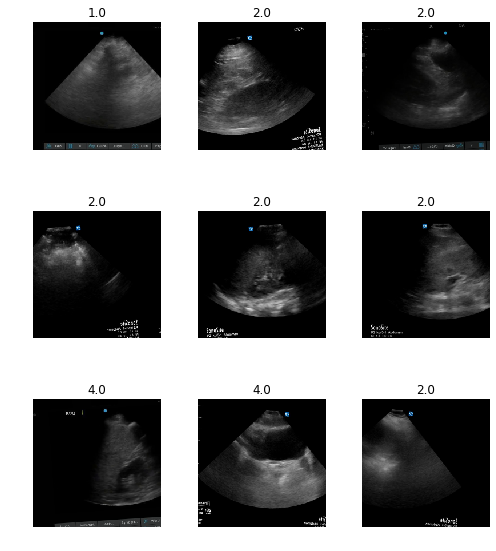

In [133]:
data.show_batch(rows=3, figsize = (7,8))

In [154]:
learn = cnn_learner(data, models.resnet34, metrics = mean_absolute_error, wd = 15)

In [155]:
#torch.nn.modules.Sigmoid??

In [156]:
def sigmoid_1to5(input, buffer=0):
    return (4+2*buffer) + torch.sigmoid(input) + (1-buffer)

class Sigmoid_1to5(torch.nn.Module):    
    def sigmoid_1to5(self, input, buffer=0):
        return (4+2*buffer) * torch.sigmoid(input) + (1-buffer)
    
    def forward(self, input):
        return self.sigmoid_1to5(input, buffer=3)

In [157]:
sig = Sigmoid_1to5()


In [158]:
x=torch.tensor(np.linspace(-10, 10, 50).astype(float))
y=sig(x)

In [159]:
learn.model[1].add_module(module = Sigmoid_1to5(), name = '9')

In [160]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

epoch,train_loss,valid_loss,mean_absolute_error,time
0,5.628165,2.617281,1.228656,00:07
1,4.856145,1.410586,0.958007,00:07
2,3.888506,1.169692,0.880089,00:07
3,3.021030,1.181308,0.909252,00:07
4,2.348876,1.184545,0.916568,00:07
5,1.911057,1.276718,0.945809,00:07
6,1.605100,1.276515,0.946935,00:07
7,1.392352,1.254766,0.930994,00:07
8,1.243231,1.156159,0.889116,00:07
9,1.130220,1.077777,0.853423,00:07


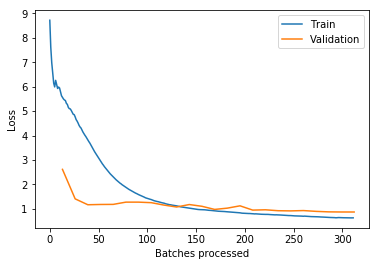

In [161]:
learn.fit_one_cycle(24)
learn.recorder.plot_losses()

In [162]:
learn.save('Test-1')

In [166]:
learn.unfreeze()

In [167]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


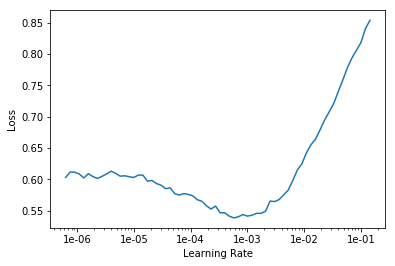

In [168]:
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.609612,0.847998,0.755638,00:07
1,0.572716,0.843394,0.745008,00:07
2,0.526822,0.854637,0.754807,00:07
3,0.473993,0.830511,0.752546,00:07
4,0.438207,0.799071,0.731662,00:07
5,0.400644,0.761251,0.710701,00:07
6,0.363255,0.781417,0.703125,00:07
7,0.328506,0.738199,0.684630,00:08
8,0.297118,0.757503,0.689375,00:07
9,0.271604,0.725179,0.677323,00:08


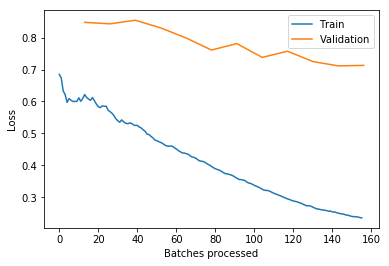

In [169]:
learn.fit_one_cycle(12, max_lr=slice(3e-05,1e-04))
learn.recorder.plot_losses()

In [74]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [170]:
#This grabs all the predictions for the validation set.
#The outputs is a 2 element Tensor with the first element being the predictions and the second element being the ground truths
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [171]:
Valid_DF = pd.DataFrame([], columns = ['Predicted', 'Actual']).reset_index()
Valid_DF.head()

,index,Predicted,Actual


In [172]:
i = 0
for x,y in zip(preds[0], preds[1]):
    dfnew = pd.DataFrame({'Predicted': float(x), 'Actual': float(y)}, index = [i])
    Valid_DF = Valid_DF.append(dfnew, ignore_index=False)

In [173]:
### Outdated method ###
# i = 0
# batchnum = 0
# while batchnum < 3:
#     xb, yb = data.one_batch(ds_type = DatasetType.Valid)
#     xb=xb.cuda()
#     ypred = learn.model(xb).cpu().detach().numpy()
#     for x, y in zip(ypred, yb.numpy()):
#         dfnew = pd.DataFrame({'Predicted': float(x), 'Actual': float(y)}, index = [i])
#         Valid_DF = Valid_DF.append(dfnew, ignore_index=False)
#         i = i + 1
#     batchnum=+1

In [1]:
Valid_DF.head()
Valid_DF.to_csv('results.csv')

NameError: name 'Valid_DF' is not defined

[1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 3, 2, 3, 3, 3, 3, 4, 3, 2, 2, 3, 4, 4, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 4, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 4, 2, 3, 3, 3, 4, 4, 4, 3, 3, 3, 2, 4, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 2, 4, 4, 4, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 2, 1, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4]
Confusion matrix, without normalization
[[12 22  1  0  0]
 [ 1 48 20  0  0]
 [ 1 15 36 10  0]
 [ 0  3 30 10  0]
 [ 1  1  5 18  0]]


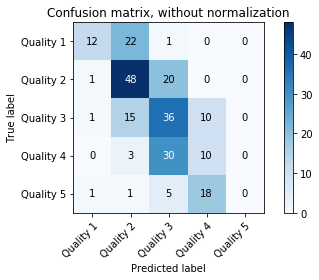

In [153]:
# confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  

CalQual = Valid_DF["Predicted"].values.tolist()
i = 0
for x in CalQual:
  if x<1:
    CalQual[i] = 1
  elif x> 5:
    CalQual[i] = 5
  else:
    CalQual[i] = round(x)
  i = i + 1
  
print(CalQual) 
  
TruQual = Valid_DF['Actual'].values.tolist()

a = plot_confusion_matrix(TruQual, CalQual, classes = ['Quality 1', 'Quality 2', 'Quality 3', 'Quality 4', 'Quality 5']) 
  
#plt.savefig("confusion_matrix_WOnorm.png")

In [199]:
def test_fn(arg1, add_sigma=False):
    print(arg1)
    
    if(add_sigma):
        print(add_sigma)
        
def test_fn(arg1, **kwargs):
    print(arg1)
    
    add_sigma = kwargs.get('add_sigma')
    
    if(add_sigma is not None and add_sigma==True):
        print(add_sigma)

In [201]:
test_fn(5, 4, arg3='hello', add_sigma='No!!!')

TypeError: test_fn() takes 1 positional argument but 2 were given

## RESNET 50

In [90]:
learn2 = cnn_learner(data, models.resnet50, metrics = mean_absolute_error)

In [91]:
learn2.fit_one_cycle(12)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,9.286983,11.918430,3.263761,00:12
1,8.489308,10.116733,2.975995,00:08
2,7.279351,3.086784,1.456157,00:08
3,5.529927,1.864127,1.082813,00:08
4,4.221506,1.166993,0.880349,00:08
5,3.358155,1.155834,0.896107,00:08
6,2.727327,1.192101,0.883848,00:08
7,2.240418,1.086237,0.850643,00:08
8,1.880705,0.991900,0.821274,00:08
9,1.615084,0.996682,0.816715,00:08


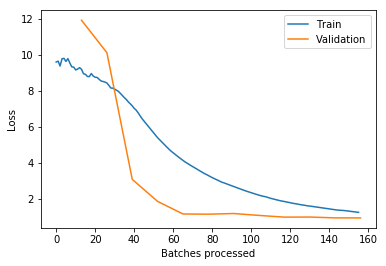

In [93]:
learn2.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


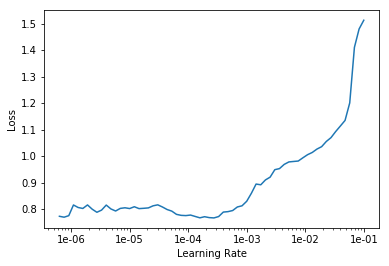

In [94]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.773828,0.945766,0.796726,00:08
1,0.810001,0.950327,0.797653,00:08
2,0.776439,0.948971,0.795623,00:08
3,0.766475,0.969003,0.805179,00:08
4,0.762246,0.942455,0.791648,00:08
5,0.738901,0.938736,0.790143,00:08
6,0.731104,0.945171,0.795291,00:08
7,0.737219,0.941966,0.793518,00:08
8,0.728049,0.931591,0.788105,00:08
9,0.717539,0.932894,0.790413,00:08


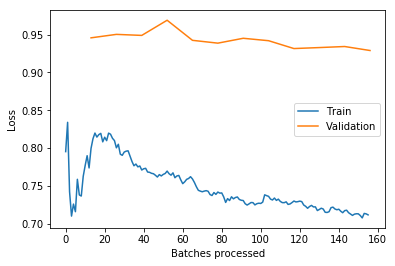

In [95]:
learn2.fit_one_cycle(12, max_lr=slice(3e-05,1.5e-04))
learn2.recorder.plot_losses()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.701769,0.930196,0.786817,00:08
1,0.719644,0.925859,0.784110,00:08
2,0.717179,0.915754,0.777580,00:08
3,0.724021,0.926400,0.784525,00:08
4,0.703544,0.924809,0.780664,00:08
5,0.680908,0.916139,0.775311,00:08
6,0.699634,0.917839,0.772465,00:08
7,0.691749,0.913381,0.770167,00:08
8,0.685273,0.901461,0.763477,00:08
9,0.687274,0.920109,0.770701,00:08


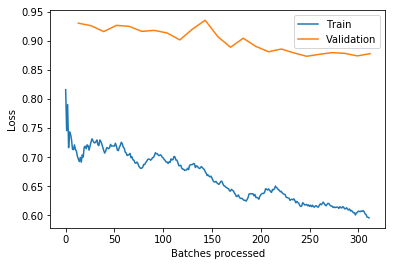

In [96]:
learn2.fit_one_cycle(24, max_lr=slice(3e-05,1.5e-04))
learn2.recorder.plot_losses()